In [1]:
import pandas as pd
import numpy as np
import sobol_seq as sob
from multi_step import multi_step, utils
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
gpflow.config.set_default_float("float32")

Setting the default backend to "tensorflow". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: tensorflow


In [24]:
plotGP = True

def GPPlotter(stage, data, stageVar, stageOutputVar):
    ## generate test points for prediction
    # xx = np.linspace(stage.inputRanges[stageVar][0], stage.inputRanges[stageVar][1], 100).reshape(100, 1)  # test points must be of shape (N, D)
    #7
    xx = data.to_numpy(dtype=np.float32)[:7,:len(stage.inputRanges)]
    yy = data.to_numpy(dtype=np.float32)[:7,len(stage.inputRanges):]

    print(xx[:,stageVar])
    print(yy[:,stageOutputVar])

    ## predict mean and variance of latent GP at test points
    mean, var = stage.model.predict_f(xx)

    print(mean)
    print(var)

    ## generate 10 samples from posterior
    tf.random.set_seed(1)  # for reproducibility
    samples = stage.model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot
    plt.figure(figsize=(12, 6))
    plt.plot(xx[:,stageVar], yy[:,stageOutputVar], "kx", mew=2)
    plt.plot(xx[:,stageVar], mean[:,stageOutputVar], "C0", lw=2)
    plt.fill_between(
        xx[:, stageVar],
        mean[:, stageOutputVar] - 1.96 * np.sqrt(var[:, stageOutputVar]),
        mean[:, stageOutputVar] + 1.96 * np.sqrt(var[:, stageOutputVar]),
        color="C0",
        alpha=0.2,
    )

    plt.plot(xx[:,stageVar], samples[:, :, stageOutputVar].numpy().T, "C0", linewidth=0.5)

In [3]:
# Define the stage input ranges

#'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
stage1Ranges = [[70,110],[0.15,0.35],[4,7],[0.4,0.8],[0,0.35],[0.05,0.4],[0.1,270]]
# #'T','Q_liq','Q_gas','a-terpinene','g-terpinene','terpinolene','radical_initiator','time'
# stage2Ranges = [[80,150],[0.1,5],[5,120],[0,2],[0,2],[0,2],[0,2],[0,240]]
#'a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'
stage2Ranges = [[0,2],[0,2],[0,2],[80,150],[0.1,5],[5,120],[0,2],[0,240]]
# 'out_11','out_12','out_13','out_14','out_2','ox','T'
stage3Ranges = [[0,1],[0,3],[0,2],[0,2],[0,1],[0,21],[100,150]]

In [4]:
def Stage_3(inputs):
    out_3 = 71.05*(1-np.exp(-0.1657 * inputs[:,5]))*(1-np.exp(-0.2*(inputs[:,6]-100)))
    out_4 = 1.04 * out_3/100 * ( (inputs[:,3] + inputs[:,4]/100 * (inputs[:,0]+inputs[:,1]+inputs[:,2])) )
    return out_4

def sobolSequenceConditions(condition_ranges, num_points):
    """"""
    dimensions = len(condition_ranges)
    sobol_sequence = sob.i4_sobol_generate(dimensions, num_points)
    lower_bounds = np.array([condition[0] for condition in condition_ranges])
    upper_bounds = np.array([condition[1] for condition in condition_ranges])
    ranges = upper_bounds - lower_bounds
    offset = np.tile(lower_bounds,(num_points,1))
    conditions = sobol_sequence * ranges + offset
    return np.array(conditions)

# ('out_11','out_12','out_13','out_14','out_2','ox','T')
stage_3_inputs = sobolSequenceConditions(stage3Ranges,10)
stage_3_outputs = Stage_3(stage_3_inputs)

In [5]:
data_s1 = pd.read_csv('data/Stage_1.csv')
data_s2 = pd.read_csv('data/Stage_2.csv')
data_s3 = pd.DataFrame(np.concatenate((stage_3_inputs,np.expand_dims(stage_3_outputs,1)),axis=1),
          columns=['out_11','out_12','out_13','out_14','out_2','ox','T','out_3'])

In [6]:
def fit_stage(data, inputHeaders, outputHeaders):
    X = data[inputHeaders]
    Y = data[outputHeaders]
    kernel = gpflow.kernels.Matern52()
    # meanFunc = gpflow.mean_functions.Linear()
    gp = gpflow.models.GPR(data=(X,Y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    optLogs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))
    return gp

In [7]:
# Fit the stages
stage1Model = fit_stage(data_s1, inputHeaders=['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'],
                        outputHeaders=['limonene','alpha-terpinene','gamma-terpinene','terpinolene','p-cymene',
                                       'alpha-terpinene-output','gamma-terpinene-output','terpinolene-output','p-cymene-output'])
# stage2Model = fit_stage(data_s2, inputHeaders=['T','Q_liq','Q_gas','a-terpinene','g-terpinene','terpinolene','radical_initiator','time'],
#                         outputHeaders=['Y2'])
stage2Model = fit_stage(data_s2, inputHeaders=['a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'],
                        outputHeaders=['Y2'])
stage3Model = fit_stage(data_s3, inputHeaders=['out_11','out_12','out_13','out_14','out_2','ox','T'],
                        outputHeaders=['out_3'])

In [8]:
# Generate the multi_step class
multi_step_graph = multi_step.multi_step_graph('adam')

In [9]:
# Load the models into the framework

#Define the stages
# stageID, stageModel, conditionRanges, followingStages (followingStageID, feedingVariables)
stage1 = utils.stage(0, stage1Model, stage1Ranges, outputDimension=9, followingStages=[[1, [1,2,3]], [2, [1,2,3,4]]])
stage2 = utils.stage(1, stage2Model, stage2Ranges[3:], outputDimension=1, followingStages=[[2,[0]]])
stage3 = utils.stage(2, stage3Model, stage3Ranges[5:], outputDimension=1)

stages = [stage1, stage2, stage3]

multi_step_graph.loadModels(stages)

c:\users\geeso\onedrive - university of cambridge\year_1\pietro\multi-step-framework\venv\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


[  0.  12.  65. 117. 154. 198. 245.]
[0.2784 0.2752 0.3168 0.3488 0.3648 0.3776 0.3872]
tf.Tensor(
[[ 0.24820358 -0.02095857 -0.0339954  -0.06105124  0.00792552 -0.02015426
  -0.03269079 -0.05870829  0.00762136]
 [ 0.26933587 -0.08554722 -0.05486901 -0.0683048   0.0097117  -0.08226421
  -0.05276334 -0.06568351  0.009339  ]
 [ 0.3129068  -0.10158141 -0.01390223  0.05648392  0.02146751 -0.09768303
  -0.01336871  0.05431622  0.02064367]
 [ 0.37163755  0.14446856  0.2495636   0.3525343   0.05424969  0.13892433
   0.23998618  0.33900544  0.05216777]
 [ 0.39954862  0.11998555  0.24288559  0.53003156  0.08253241  0.11538085
   0.23356451  0.5096907   0.07936512]
 [ 0.37406123  0.5744176   0.5190517   0.7616993   0.10020438  0.5523734
   0.49913216  0.7324681   0.09635883]
 [ 0.38649884  0.6331205   0.56997025  0.8613111   0.1191401   0.60882354
   0.5480967   0.8282571   0.11456789]], shape=(7, 9), dtype=float32)
tf.Tensor(
[[0.00378418 0.00378418 0.00378418 0.00378418 0.00378418 0.00378418
 

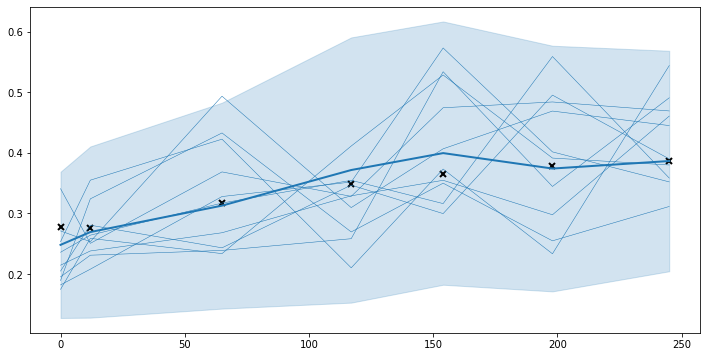

In [25]:
if plotGP == True:
    GPPlotter(stage1,data_s1,6,0)

In [11]:
# Define the objective functions

# def objectiveFunction1(var1, var2, var3, var4, var5):
#     out_4 = 1.04 * var5/100 * ( (var4 + inputs[:,4]/100 * (var1+var2+var3)) )
#     return out_4

def objectiveFunction1(var1):
    return var1

# def objectiveFunction2(var1, var2, var3, var4):
#     return (var1+var4)**2-var3**2+var2**2

# Define the objective objects including the objective functions and the IDs of relevant variables/outputs
# Define objective variables with form: [stage, 'input'/'output', stage variable]
objective1 = utils.objective(objectiveFunction1, [[stage3,'outputs',0]])
# objective2 = utils.objective(objectiveFunction2,[[stage1,'outputs',1],[stage2,'outputs',0],[stage3,'inputs',1],[stage2,'outputs',1]])

# objectives = [objective1, objective2]
objectives = [objective1]

In [12]:
# Define the objectives for the framework
multi_step_graph.defineObjectives(objectives)

In [13]:
# Optimise the process
# numObjectiveSamples, preferenceCodeDim, hyperparameterGeneratorDim, epochs=5, h_dim=5, n_layers=4, network_type='GATConv', **kwargs
multi_step_graph.train(1, 4, 100, epochs=50, h_dim=5, n_layers=4, network_type='GATConv', num_heads=3)

Starting training
Weightings: [1.], Epoch: 0, Loss: -3.468257291645223e-25
dict_values([<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 90.04301   ,   0.2501543 ,   5.49962   ,   0.5997973 ,
         0.17469604,   0.22575292, 135.32542   ], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([114.80393  ,   2.5681915,  62.7235   ,   0.9907487, 119.92702  ],
      dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 10.550901, 125.09819 ], dtype=float32)>])
Weightings: [1.], Epoch: 10, Loss: -3.464437725749756e-25
dict_values([<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 90.06162   ,   0.25021192,   5.499433  ,   0.59970886,
         0.17460743,   0.22609256, 135.2925    ], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([114.787926 ,   2.5696094,  62.729713 ,   0.9891253, 119.99232  ],
      dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 10.559267, 125.10803 ], dtype=float32)>])
Weightings: [1.